# **Initialization** 

In [1]:
import pandas as pd
import torch

### Control

In [2]:
# Paths
RAW_DATA_FOLDER = 'raw_data'
TARGET_FILE_PATH = 'unprocessed_data'

# Flow Controls
RELOAD_RAW_DATA = False
DO_SMOTE = True
DATA = 'electrical_circuit'  # Options: 'depression', 'insomnia', 'electrical_circuit'

# System variables
STATE = 42
TEST_SET_FRACTION = 0.20
MISSING_VALUES_THRESHOLD = 0.50
SAMPLES_ELECTRICAL_CIRCUIT = 5000
VERBOSE = True

# **Data Preparation**

### Merge raw data files

In [3]:
from raw_data_loader import load_raw_data

if (RELOAD_RAW_DATA):
    load_raw_data(RAW_DATA_FOLDER, TARGET_FILE_PATH)

### Preprocessing and Split

In [3]:
from preprocessing_depression import clean_and_preprocess_depression_data
from preprocessing_insomnia import clean_and_preprocess_insomnia_data
from preprocessing_electrical_circuit import gen_and_preprocess_ec_data

dataset = pd.read_csv(TARGET_FILE_PATH + '/depression_data.csv')

if DATA == 'depression':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = clean_and_preprocess_depression_data(dataset, RAW_DATA_FOLDER, TEST_SET_FRACTION, STATE, MISSING_VALUES_THRESHOLD)
elif DATA == 'insomnia':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = clean_and_preprocess_insomnia_data(dataset, RAW_DATA_FOLDER, TEST_SET_FRACTION, STATE, MISSING_VALUES_THRESHOLD)
elif DATA == 'electrical_circuit':
    X_train, X_test, y_train, y_test, y_embed_train, y_embed_test = gen_and_preprocess_ec_data(SAMPLES_ELECTRICAL_CIRCUIT, TEST_SET_FRACTION, STATE)
else:
    raise ValueError("Invalid dataset selected")

#TODO Fix issue with the time columns SLQ300/310/320/330 in depression and processing

Basic Electrical Circuit Simulator/Generator


### Data Balancing

In [5]:
from data_balancing import resample_training_data

if DO_SMOTE:
    X_train, y_train, y_embed_train = resample_training_data(X_train, y_train, y_embed_train, random_state=STATE)

ModuleNotFoundError: No module named 'imblearn'

Class distribution:
0
0    2007
1    1993
Name: count, dtype: int64

Class ratio: 0.993


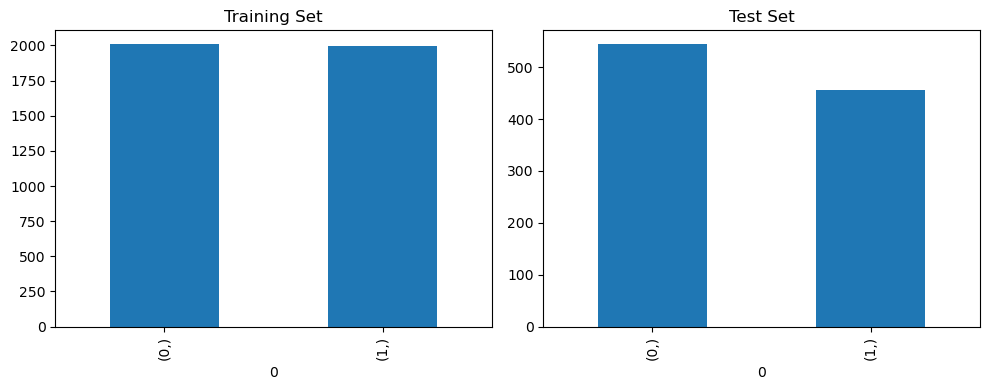

In [4]:
import matplotlib.pyplot as plt

# Check class distribution
print("Class distribution:")
print(y_train.value_counts())
print(f"\nClass ratio: {(y_train.value_counts()[1] / y_train.value_counts()[0]):.3f}")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
y_train.value_counts().plot(kind='bar', ax=ax[0], title='Training Set')
y_test.value_counts().plot(kind='bar', ax=ax[1], title='Test Set')
plt.tight_layout()
plt.show()

# **Models**

In [6]:
from baseline_models import train_multitarget_baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

### Training Bayesian Models

In [6]:
nb_model = GaussianNB()
y_pred_nb, acc_nb = train_multitarget_baseline(
                            model=nb_model,
                            is_classifier=False,
                            X_train=X_train,
                            X_test=X_test,
                            y_embed_train=y_embed_train,
                            y_embed_test=y_embed_test,
                            verbose=VERBOSE)



 ######################################## GaussianNB Multitarget Regressor ########################################
Train MSE per embedding: [ 52059.36025  41509.8905   54759.43225  63583.644    77929.185
  62877.18275 107183.147    47843.55025]
Test MSE per embedding: [ 56894.288  44889.096  63442.078  74432.063  90656.514  77874.897
 119260.47   49646.971]
Average train MSE: 63468.174
Average test MSE: 72137.047125


### Training Random Forests

In [7]:
# Parameter
N_ESTIMATORS = 100

In [8]:
rf_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=STATE, n_jobs=-1)
y_pred_rf, mse_rf = train_multitarget_baseline(
                                    model=rf_model, 
                                    is_classifier=False, 
                                    X_train=X_train, 
                                    X_test=X_test, 
                                    y_embed_train=y_embed_train, 
                                    y_embed_test=y_embed_test,
                                    verbose=VERBOSE)



 ######################################## RandomForestRegressor Multitarget Regressor ########################################
Train MSE per embedding: [ 495.97067715  696.42313045  593.53877665  391.28257722  123.41573847
 3346.21772207 5408.1000016   502.34868655]
Test MSE per embedding: [ 2943.6461006  5329.0526277  4048.9118285  2540.1975794   734.7480725
 24310.930406  40204.2232533  3802.708152 ]
Average train MSE: 1444.6621637718752
Average test MSE: 10489.302252499998


### Training Logistic Models

In [9]:
# Parameters
MAX_ITERATIONS = 1000

In [10]:
log_model = LogisticRegression(max_iter=MAX_ITERATIONS, class_weight='balanced', random_state=STATE)
y_pred_log, acc_log = train_multitarget_baseline(
                            model=log_model,
                            is_classifier=True,
                            X_train=X_train,
                            X_test=X_test,
                            y_embed_train=y_embed_train,
                            y_embed_test=y_embed_test,
                            verbose=VERBOSE)



 ######################################## LogisticRegression Multitarget Classifier ########################################
Train accuracy per embedding: [0.06525 0.069   0.06175 0.0595  0.0595  0.056   0.0525  0.061  ]
Test accuracy per embedding: [0.003 0.003 0.001 0.001 0.002 0.001 0.001 0.002]
Average train accuracy: 0.0605625
Average test accuracy: 0.00175


## Proposed MLPs

In [5]:
from proposed_models import train_joint_model, train_split_model, train_deep_joint_model, train_deep_split_model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
E_KEEP_RATE = 0.7
l = 1
if DATA == 'depression':
    l = 1e-2
elif DATA == 'insomnia':
    l = 1e-2
elif DATA == 'electrical_circuit':
    l = 1

### Train Joint MLP

In [6]:
train_joint_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test, e_kept_ratio=E_KEEP_RATE, l=l, device=DEVICE, epochs=100 )

Training:	#################################################-	[99.0%]
===============================    Joint MLP    ===============================
Regression Results:
MSE:	119477.1328125


Classification Results:
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       544
           1       0.00      0.00      0.00       456

    accuracy                           0.54      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.30      0.54      0.38      1000

Confusion matrix:
 [[544   0]
 [456   0]]
Training:	--------------------------------------------------	[0.0%]

/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Training:	#################################################-	[99.0%]
=========================    Joint MLP (Augmented)    =========================
Regression Results:
MSE:	118320.65625


Classification Results:
F1 score: 0.6263736263736264
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       544
           1       0.46      1.00      0.63       456

    accuracy                           0.46      1000
   macro avg       0.23      0.50      0.31      1000
weighted avg       0.21      0.46      0.29      1000

Confusion matrix:
 [[  0 544]
 [  0 456]]


/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Train Split MLP

In [7]:
train_split_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test, e_kept_ratio=E_KEEP_RATE, device=DEVICE, epochs=100 )

Training:	#################################################-	[99.0%]
===============================    Split MLP    ===============================
Regression Results:
MSE:	120139.2265625


Classification Results:
F1 score: 0.6186440677966102
              precision    recall  f1-score   support

           0       0.55      0.04      0.08       544
           1       0.46      0.96      0.62       456

    accuracy                           0.46      1000
   macro avg       0.50      0.50      0.35      1000
weighted avg       0.51      0.46      0.32      1000

Confusion matrix:
 [[ 22 522]
 [ 18 438]]
Training:	#################################################-	[99.0%]
=========================    Split MLP (Augmented)    =========================
Regression Results:
MSE:	332452.125


Classification Results:
F1 score: 0.4732824427480916
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       544
           1       0.47      0.48     

### Train Deep Joint Model

In [8]:
train_deep_joint_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test, e_kept_ratio=E_KEEP_RATE, l=1, device=DEVICE, epochs=100 )

Training:	#################################################-	[99.0%]
=============================    Deep Joint MLP    =============================
Regression Results:
MSE:	91248.0078125


Classification Results:
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       544
           1       0.00      0.00      0.00       456

    accuracy                           0.54      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.30      0.54      0.38      1000

Confusion matrix:
 [[544   0]
 [456   0]]
Training:	--------------------------------------------------	[0.0%]

/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Training:	#################################################-	[99.0%]
=======================    Deep Joint MLP (Augmented)    =======================
Regression Results:
MSE:	91822.6640625


Classification Results:
F1 score: 0.6263736263736264
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       544
           1       0.46      1.00      0.63       456

    accuracy                           0.46      1000
   macro avg       0.23      0.50      0.31      1000
weighted avg       0.21      0.46      0.29      1000

Confusion matrix:
 [[  0 544]
 [  0 456]]


/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Train Deep Split Model

In [9]:
train_deep_split_model( X_train, X_test, y_train, y_test, y_embed_train, y_embed_test, e_kept_ratio=E_KEEP_RATE, device=DEVICE, epochs=100 )

Training:	#################################################-	[99.0%]
=============================    Deep Split MLP    =============================
Regression Results:
MSE:	101002.75


Classification Results:
F1 score: 0.0
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       544
           1       0.00      0.00      0.00       456

    accuracy                           0.54      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.30      0.54      0.38      1000

Confusion matrix:
 [[544   0]
 [456   0]]
Training:	--------------------------------------------------	[0.0%]

/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Training:	#################################################-	[99.0%]
=======================    Deep Split MLP (Augmented)    =======================
Regression Results:
MSE:	99248.640625


Classification Results:
F1 score: 0.6263736263736264
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       544
           1       0.46      1.00      0.63       456

    accuracy                           0.46      1000
   macro avg       0.23      0.50      0.31      1000
weighted avg       0.21      0.46      0.29      1000

Confusion matrix:
 [[  0 544]
 [  0 456]]


/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
